# Broadband source analysis

Switching to a broadband light source would dramatically reduce the footprint of scan rigs, and likely eliminate speckle. How much signal/crosstalk can we expect with our current filters?

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from camera import Camera
from objective import Objective
from broadbandSource import BroadbandSource
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'
sourcesPath = 'Source spectra/'

__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/


Next, define (manually and in a boilerplate-y manner) the components of the system we are investigating. 

In [2]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )         
          
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)

bb = BroadbandSource(name='Thorlabs HPLS343, 3mm LLG', 
                     integratedPowermW=4000.0, 
                     spectrum=os.path.join(sourcesPath, 'Thorlabs Plasma Source.txt'))
             
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700new = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )
                   
                   
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'))

objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))



## Broadband source, signal from each dye

Compare signal from each dye in it's proper detection channel between current, laser-based system and putative broadband source system. 

L405Nm
broadband/laser ratio = 41.967
L532Nm
broadband/laser ratio = 2.687
L594Nm
broadband/laser ratio = 2.322
L633Nm
broadband/laser ratio = 3.006
L700Nm
broadband/laser ratio = 3.447


<IPython.core.display.Javascript object>


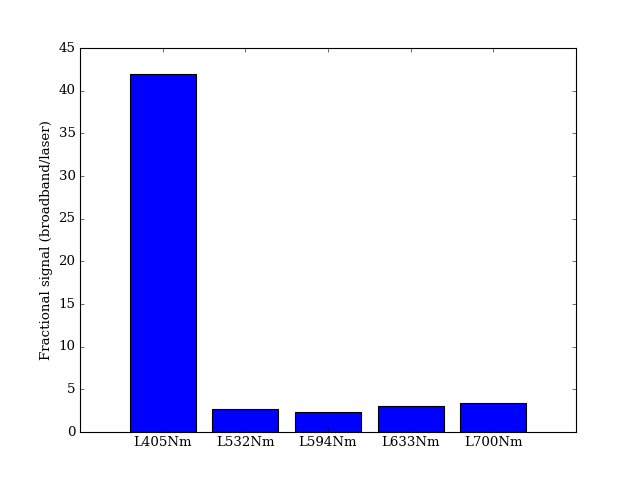

In [6]:
% matplotlib notebook
ratios = []
ch_labels = []

laser_list = [l405, l532, l594, l633, l700]
fc_list = [fc405, fc532, fc594, fc633, fc700new]
dye_list = [dye405, dye532, dye594, dye633, dye700]
source_list = [bb, bb, bb, bb, bb]

for l, b, fc, dy in zip(laser_list, source_list, fc_list, dye_list):
    d, ch, sig_new = signalFromDyeXInChannelY(b, fc, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, fc, dy, objective, camera)
    print(ch)
    print('broadband/laser ratio = {:0.3f}'.format((sig_new/sig_old)))
    
    ratios.append(sig_new/sig_old)
    ch_labels.append(ch)
    
fig3 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        ratios, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal (broadband/laser)')
plt.show()

## Crosstalk

Assemble crosstalk matrices for current, laser-based setup and putative broadband setup. 

<IPython.core.display.Javascript object>


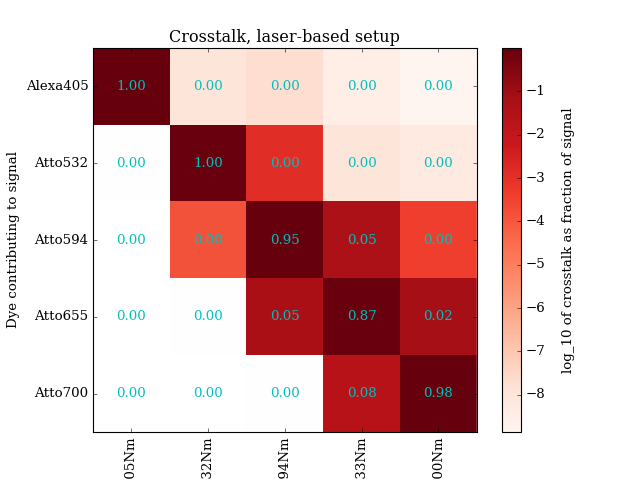

C:\Users\d.kelly\Documents\DyeAnalysis\crosstalk_analysis.py:101: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(crosstalkMatrix), cmap = 'Reds', interpolation='none')


<IPython.core.display.Javascript object>


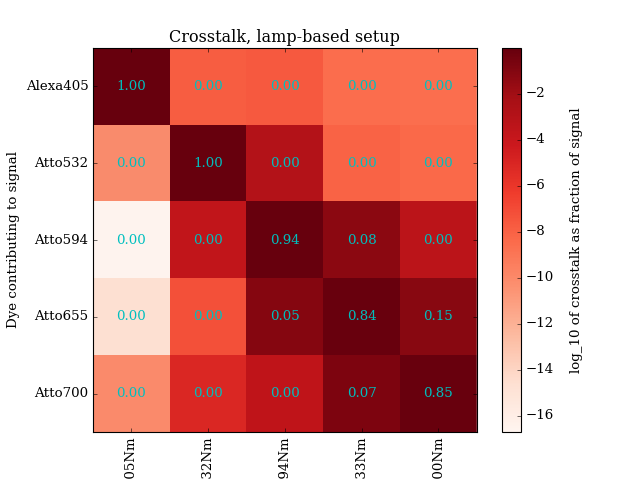

In [5]:
displayCrosstalkPlot(laser_list, 
                     fc_list, 
                     dye_list, 
                     objective, camera)
plt.title('Crosstalk, laser-based setup')
displayCrosstalkPlot(source_list, 
                     fc_list, 
                     dye_list, 
                     objective, camera)
plt.title('Crosstalk, lamp-based setup')